<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Identifying west nile virus hotspots and its exacerbating factors


# Overview

### Introduction
The West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. The virus is most commonly spread to people by the bite of an infected mosquito, although it can also spread through organ transplant, blood transfusions and breast milk ([CDC](https://www.cdc.gov/westnile/index.html)).

Most people infected with the WNV do not feel sick. Of those infected, 1 in 5 develop mild symptoms while 1 in 150 develop a serious, sometimes fatal, illness. Nonetheless, it is important to note that there is currently no human vaccine available. As such, the only way to reduce infection in people is by  reducing exposure to the virus ([WHO, 2017](https://www.who.int/news-room/fact-sheets/detail/west-nile-virus)).

### Problem Statement
As an analyst in the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), you have been tasked to predict when and where different species of mosquitos will test positive for WNV in the City of Chicago. Subsequently, a cost-benefit analysis should be conducted. This should include annual cost projections for various levels of pesticide coverage (cost) and the effect of these various levels of pesticide coverage (benefit).

This will help the City of Chicago and the Chicago Department of Public Health (CDPH) more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

### Method
#<\to insert>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)

# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

In [ ]:
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

In [ ]:
train.head()

In [ ]:
test.head()

# Contents
- [Cleaning Train Dataset](#Cleaning-Train-Dataset)
- [Cleaning Test Dataset](#Cleaning-Test-Dataset)
- [Cleaning Weather Dataset](#Cleaning-Weather-Dataset)
- [Cleaning Spray Dataset](#Cleaning-Spray-Dataset)

## Cleaning Train & Test Dataset

In [ ]:
train.head(5)

In [ ]:
# convert all to lower case
train.columns = [word.lower() for word in train.columns]

In [ ]:
train.info()

Check null

In [ ]:
# no null values 
train.isnull().sum()

In [ ]:
# Distribution of mosquitos found

plt.hist(train['nummosquitos'], bins=50)
plt.title("Histogram of Mosquitos in each Trap");

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50.

**Assumption**<br/>
If the mosquito traps are only inspected ONCE a day, we will only expect more than one entry for the specific location/trap/date if one of the entry has 50 mosquitos.

In [ ]:
# Create a list of columns without 'nummosquitos'

col_w = list(train.columns)
col_w.remove('nummosquitos') # this includes all the column names except for 'nummosquitos'

In [ ]:
# Inspect dulplicated rows where number of mosquito count is less than 50

mos_u50 = train.loc[train['nummosquitos']<50,:] # slice data for nummosquitos < 50

dup = mos_u50[col_w].duplicated(keep=False) # find index of data which have same are duplicates except 'nummosquitos'

In [ ]:
# View some data which are duplicates except 'nummosquitos'

mos_u50[dup][:6] 

There are entries that have the same date, location, trap with different number of mosquitos.

This means that the data is not entered as we expect. These could be due to data entry errors, traps are checked more than once a day or others. However, it is impossible to discern. We will assume that all datapoints are VALID. (ie. traps are checked several times a day or the like.)

In [ ]:
# To merge rows if they have the same date, location, trap
# Create new column to identify those with wnv

col_w.remove('wnvpresent') # col_w includes all columns except wnvpresent and nummosquitos

train_1 = train.groupby(col_w, as_index=False).sum()

# Refresh 'wnvpresent' variable (ie wnvpresent indicates whether the trap has wnv or not)
train_1['wnvcount'] = train_1['wnvpresent']
train_1['wnvpresent'] = train_1['wnvpresent'].map(lambda x: 1 if x > 0 else 0)


In [ ]:
# base rate of wnvpresent AFTER transformation

train_1['wnvpresent'].value_counts(normalize=True)

In [ ]:
# Inspect mosquito species and WNY presence

train_1.groupby(['species'])[['nummosquitos', 'wnvpresent']].agg({'nummosquitos': ['sum'],
                                                                'wnvpresent': ['sum', 'mean']})

Most of the mosquitos found are Culex Pipiens and Culex Restuans which are the only species which were detected to have the West Nile Virus. This is because this two species are more common in the US. Nonetheless, all the species of Culex indicated can potentially transmitt the virus.([CDC](https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf))

In [ ]:
# Create dataframe which collapse the species column for Visualisation

col_w.remove('species') # ie all columns except wnvpresent, nummosquitos amd species

train_2 = train_1.groupby(col_w, as_index=False).sum()

# Refresh 'wnvpresent' variable (ie if wnvpresent or not)
train_2['wnvpresent'] = train_2['wnvpresent'].map(lambda x: 1 if x > 0 else 0)

In [ ]:
train_2['date'] = pd.to_datetime(train_2['date'])
train_2['year'] = train_2['date'].dt.year
train_2['month'] = train_2['date'].dt.month

In [ ]:
train_plot = train_2.copy()

train_plot = train_plot.groupby(["year", "month"], as_index=False).sum()
train_plot['month'] = train_plot['month'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})

fig, ax = plt.subplots(nrows =2, ncols =1, figsize =(10,10))

sns.barplot(x="year", y="nummosquitos", hue="month", data=train_plot, ax=ax[0])
ax[0].set_title("Total Number of mosquitos per month", fontsize=10)
ax[0].set_xlabel('')
ax[0].set_ylabel("Number of Mosquitos", fontsize=10)

sns.barplot(x="year", y="wnvpresent", hue="month", data=train_plot, ax=ax[1])
ax[1].set_title("Total Number of traps with WNV present per month", fontsize=10)
ax[1].set_xlabel('')
ax[1].set_ylabel(" Number of Traps with WNV", fontsize=10)

plt.subplots_adjust(hspace=0.4)

There seem to be a cyclical trend of number of mosquitos caught in traps across the years. The number of mosquitos appear to pick up in June/July, before declining in seems to be picking up from June to August. 

In [ ]:
# Create a dataframe for each year with lat long and the cumulative occurence of virus
# col_w.remove('species')
to_keep = ['date', 'latitude', 'longitude', 'wnvpresent']

train_plot = train_2[to_keep].copy()

train_plot['date'] = pd.to_datetime(train_plot['date']) # convert date type
train_plot['year'] = train_plot['date'].dt.year         # create another column of date
train_plot.drop(columns='date', inplace=True)


train_plot = train_plot.groupby(['year', 'latitude', 'longitude']).sum() # collapse rows that have same values in columns col_w
train_plot.reset_index(inplace=True)    # create new df from those collapsed rows

train_plot.rename(columns={'wnvpresent': 'wnvcount', # Rename column names to the appropriate one
                       }, inplace=True)

train_plot_2007 = train_plot.loc[train_plot['year']==2007, :]
train_plot_2009 = train_plot.loc[train_plot['year']==2009, :]
train_plot_2011 = train_plot.loc[train_plot['year']==2011, :]
train_plot_2013 = train_plot.loc[train_plot['year']==2013, :]

In [ ]:
mapdata = np.loadtxt("../BackupData/mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)


# Plot for 2007
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
ax[0].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007 = train_plot_2007.loc[:, ['longitude', 'latitude']]

ax[0].scatter(locations_2007['longitude'], locations_2007['latitude'],
            s=train_plot_2007.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[0].set_title('Traps with WNV - 2007')


# Plot for 2009
ax[1].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009 = train_plot_2009.loc[:, ['longitude', 'latitude']]

ax[1].scatter(locations_2009['longitude'], locations_2009['latitude'],
            s=train_plot_2009.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[1].set_title('Traps with WNV - 2009')

# Plot for 2011
ax[2].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011 = train_plot_2011.loc[:, ['longitude', 'latitude']]

ax[2].scatter(locations_2011['longitude'], locations_2011['latitude'],
            s=train_plot_2011.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[2].set_title('Traps with WNV - 2011')

# Plot for 2013
ax[3].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013 = train_plot_2013.loc[:, ['longitude', 'latitude']]

ax[3].scatter(locations_2013['longitude'], locations_2013['latitude'],
            s=train_plot_2013.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[3].set_title('Traps with WNV - 2013')

In [ ]:
train_plot_2007_top = train_plot_2007.sort_values('wnvcount', ascending=False)[:5]
train_plot_2009_top = train_plot_2009.sort_values('wnvcount', ascending=False)[:5]
train_plot_2011_top = train_plot_2011.sort_values('wnvcount', ascending=False)[:5]
train_plot_2013_top = train_plot_2013.sort_values('wnvcount', ascending=False)[:5]

In [ ]:
# Plot for 2007
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
ax[0].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007 = train_plot_2007_top.loc[:, ['longitude', 'latitude']]

ax[0].scatter(locations_2007['longitude'], locations_2007['latitude'],
            s=train_plot_2007_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[0].set_title('Traps with WNV - 2007')


# Plot for 2009
ax[1].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009 = train_plot_2009_top.loc[:, ['longitude', 'latitude']]

ax[1].scatter(locations_2009['longitude'], locations_2009['latitude'],
            s=train_plot_2009_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[1].set_title('Traps with WNV - 2009')

# Plot for 2011
ax[2].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011 = train_plot_2011_top.loc[:, ['longitude', 'latitude']]

ax[2].scatter(locations_2011['longitude'], locations_2011['latitude'],
            s=train_plot_2011_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[2].set_title('Traps with WNV - 2011')

# Plot for 2013
ax[3].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013 = train_plot_2013_top.loc[:, ['longitude', 'latitude']]

ax[3].scatter(locations_2013['longitude'], locations_2013['latitude'],
            s=train_plot_2013_top.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[3].set_title('Traps with WNV - 2013')

Top 5 highest mosquito counts coming from these 5 locations. 

In [ ]:
# Find out the distribution of intervals between trap findings

m_dates = train_2[['date', 'trap', 'year']].sort_values(['trap', 'date']).drop_duplicates(ignore_index=True)

d_liz = []
for i, v in enumerate(m_dates['date']):                 # for loop to get the day intervals between trap checks
    if i == 0:
        d_liz.append(v-v)
    else:
        d_liz.append(v-m_dates['date'][i-1])


m_dates['diff']= d_liz 
m_dates['diff_n'] = m_dates['diff'].dt.days            # save day intervals to integer
m_dates_rmfirst = m_dates[m_dates.duplicated(subset=['trap', 'year'], keep='first')] # remove first trap recorded in the year


In [ ]:
# plot the distribution of intervals between trap checks

m_dates_rmfirst.loc[:, 'diff_n'].hist(bins=50)
m_dates_rmfirst[['diff_n']].describe()

As records are only provided for positive mosquito counts, we are unable to conclude if the intervals represent the frequency of trap checks. Nonetheless, it reflects the data available does not come in regular intervals.

In [ ]:
# Select rows required for analysis in train and test set

# train data
train_to_save = train_1[['date', 'species', 'latitude', 'longitude', 'trap',
                         'nummosquitos', 'wnvpresent', 'wnvcount']]

# test data
test.columns = [word.lower() for word in test.columns]
test_to_save = test[['date', 'species', 'latitude', 'longitude', 'trap']]


### Save cleaned train and test data to csv

In [ ]:
# Save cleaned data to csv

train_to_save.to_csv(r'../data/train_clean.csv', index = False) # combine rows where date/location/trap is the same
                                                          # nummosquitos are summed
                                                          # wnvpresent = 1 if wnvpresent >0

test_to_save.to_csv(r'../data/test_clean.csv', index = False)

## Cleaning Weather Dataset

weather.head(10)

In [ ]:
# convert all to lower case
weather.columns = [word.lower() for word in weather.columns]

In [ ]:
# convert date time 
weather['date'] = weather['date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [ ]:
# create month column 
weather['month'] = weather['date'].dt.month

In [ ]:
weather.info()

In [ ]:
print(f'Total rows for weather: {weather.shape[0]}\n')
for col in weather.columns:
    if 'M' in weather[col].unique().tolist():
        count = weather[col].value_counts()['M']
        print(f'Column {col} has {count} number of "M"');

### Approach to handle missing data

- `water1` need to drop as majority are missing values 
- `depart, depth, snowfall` have quite alot of missing values as well, need to see what are the unique values and its distribution to judge if it is usefull. 
- the `rest` will need to do imputation 

In [ ]:
# drop water1 rows since majority is M  
weather.drop(columns='water1', inplace = True)

In [ ]:
for col in ['preciptotal','depart','depth', 'snowfall']:
    plt.figure(figsize=(15,5))
    sns.histplot(x = col, data = weather)

Need to drop snowfall and depth since not much information to impute. 

Noticed there are `trace` amounts in snowfall and precipitation

In [ ]:
weather[weather.snowfall == '  T']

Snowfall has intermittent traces, hence might but be usefull as it might not hypothetically stack into bigger than 'trace' amounts

In [ ]:
# Dropping unnecessary columns.

cols_to_drop = ['depart', 'depth', 'snowfall']
weather.drop(columns=cols_to_drop, inplace=True)

In [ ]:
weather[weather.preciptotal == '  T'].head(20)

Found that trace amounts seems to be more frequent across datetime. 

In [ ]:
weather[(weather['date'] < '2007-07-01') & (weather['date'] > '2007-06-01')].head(35)

In [ ]:
weather[weather.preciptotal == '  T'].shape

Precipitation trace amounts seems to be a value more than zero and less than a certain conventional number based on the geographical area measured. We can see gradual precipitation levels converging to what we call `trace` amounts. As per ([ChicagoTribune, 2018](https://www.chicagotribune.com/weather/ct-wea-asktom-0415-20180413-column.html)), precipitation (and the water content of frozen precipitation like snow) is measured in hundredths (0.01) of an inch. "Trace" amounts are defined as less than half of precipitation 0.01 inch (0.005 inches). Hence we will `impute 0.005` for trace amounts as there are considerable rows of trace amounts 

In [ ]:
# Replacing 'T's and 'M's with 0s in some columns.

weather.preciptotal.replace(['M'], 0, inplace=True)
weather.preciptotal.replace(['  T'], 0.005, inplace=True)
weather.wetbulb.replace(['M'], 0, inplace=True)
weather.heat.replace(['M'], 0, inplace=True)
weather.cool.replace(['M'], 0, inplace=True)
weather.stnpressure.replace(['M'], 0, inplace=True)
weather.sealevel.replace(['M'], 0, inplace=True)
weather.avgspeed.replace(['M'], 0, inplace=True)

In [ ]:
# Calculate Tavg using (Tmax + Tmin)/2 to deal with 'M's in Tavg.

weather['tavg'] = (weather.tmax + weather.tmin)/2

In [ ]:
# Changing column dtypes from type object to type float.

weather.preciptotal = weather.preciptotal.astype(float)
weather.wetbulb = weather.wetbulb.astype(float)
weather.heat = weather.heat.astype(float)
weather.cool = weather.cool.astype(float)
weather.stnpressure = weather.stnpressure.astype(float)
weather.sealevel = weather.sealevel.astype(float)
weather.avgspeed = weather.avgspeed.astype(float)

In [ ]:
weather.sunrise.unique()

In [ ]:
weather.sunset.unique()

Need to normalize 24h format to float 

In [ ]:
weather.head()

In [ ]:
# find how many unique timings from station 2
weather[weather.station == 2].sunrise.unique()

Weather station 2 does not have sunrise and sunset. Assuming about the same we will impute same sunrise and sunset timings into station 2 similar to station 1

In [ ]:
# create reference to get sunrise and sunset timings from station 1 
weather_ref = weather[weather.station == 1][['date','sunrise','sunset']]

In [ ]:
# imput all sunrise and sunset timings for station 2 similar to station 1 based on 'date'

weather = weather.merge(weather_ref, on = 'date').drop(columns = ['sunrise_x', 'sunset_x']).rename(columns = {'sunrise_y': 'sunrise', 'sunset_y': 'sunset'})

In [ ]:
# Define function to help convert 24h to float (0430 -->> 4.5)

def suntime_float(sun_time):
  
  # Getting the hour part of the time to convert to the whole number part in the float number.
  hours = sun_time // 100

  # Getting the minute part of the time to convert to the decimal part in the float number.
  minutes = (sun_time % 100) / 60

  return hours + minutes

merge with weather_data_com

In [ ]:
# Creating series of sunrise and sunset times and converting them to dtype float.
sunrise_times = weather['sunrise'].astype(float)
sunset_times = weather['sunset'].astype(float)

# Mapping the above created function to convert 24h time values to floating point numbers.
weather['sunrise'] = list(sunrise_times.map(suntime_float))
weather['sunset'] = list(sunset_times.map(suntime_float))

In [ ]:
weather

Checking code sum should only have these based on Daily Table format given by Kaggle 

`FC` - Tornado

`FC` - Funnel Cloud

`TS` - Thunderstorm

`GR` - Hail

`RA` - Rain


In [ ]:
# to do code sum on individual stations
weather_station_1 = weather[weather.station == 1]
weather_station_2 = weather[weather.station == 2]

In [ ]:
# Defining a function to clean the weather conditions given in Codesum column.
def clean_codesum(string):
    return " ".join(set(" ".join(string).split(' ')))

In [ ]:
codesum_groupedby_date_stn1 = weather_station_1.groupby('date')['codesum'].agg(clean_codesum)
codesum_groupedby_date_stn2 = weather_station_2.groupby('date')['codesum'].agg(clean_codesum)

Merged codesum by date. Now need to vectorize


In [ ]:
# define function that creates dummy columns 

def vectorise_code(group):
    cvec = CountVectorizer(analyzer='word', token_pattern=r'[\w\+]+')
    code_sum_cvec = cvec.fit_transform(group)
    code_sum_df = pd.DataFrame(code_sum_cvec.toarray(),weather['date'].unique(), columns=cvec.get_feature_names_out())
    code_sum_df = code_sum_df.reset_index().rename( columns = {'index': 'date'})
    return code_sum_df

In [ ]:
# dummify codes in both stations
vect_codesum_stn1 = vectorise_code(codesum_groupedby_date_stn1)
vect_codesum_stn2 = vectorise_code(codesum_groupedby_date_stn2)

# impute station = 1 as reference
vect_codesum_stn1['station'] = 1
vect_codesum_stn2['station'] = 2

# concat both to make same shape as weather df
code_sum_df = pd.concat((vect_codesum_stn1, vect_codesum_stn2), axis=0).fillna(0)

# print out shape
print(code_sum_df.shape)
code_sum_df

In [ ]:
# check shape 

print(code_sum_df.shape)
print(weather.shape)

In [ ]:
cleaned_weather_df = weather.merge(code_sum_df, on = ['date','station'])
cleaned_weather_df

### Save cleaned weather data to csv

In [ ]:
# saving into weather_cleaned
cleaned_weather_df.to_csv(r'../data/weather_cleaned.csv', index = False)

## Weather Lag

In [ ]:
weather_station1 = cleaned_weather_df.loc[cleaned_weather_df['station'] == 1]
weather_station2 = cleaned_weather_df.loc[cleaned_weather_df['station'] == 2]

In [ ]:
weather_station1.reset_index(drop=True, inplace=True)
weather_station2.reset_index(drop=True, inplace=True)

In [ ]:
weather_station1.set_index('date', inplace=True)
weather_station2.set_index('date', inplace=True)

In [ ]:
weather_station1['date_2_lag'] = weather_station1.index.shift(2, freq='D')
weather_station1['date_3_lag'] = weather_station1.index.shift(3, freq='D')
weather_station1['date_5_lag'] = weather_station1.index.shift(5, freq='D')
weather_station1['date_7_lag'] = weather_station1.index.shift(7, freq='D')
weather_station1['date_14_lag'] = weather_station1.index.shift(14, freq='D')
weather_station1['date_21_lag'] = weather_station1.index.shift(21, freq='D')
weather_station1['date_28_lag'] = weather_station1.index.shift(28, freq='D')

In [ ]:
weather_station2['date_2_lag'] = weather_station2.index.shift(2, freq='D')
weather_station2['date_3_lag'] = weather_station2.index.shift(3, freq='D')
weather_station2['date_5_lag'] = weather_station2.index.shift(5, freq='D')
weather_station2['date_7_lag'] = weather_station2.index.shift(7, freq='D')
weather_station2['date_14_lag'] = weather_station2.index.shift(14, freq='D')
weather_station2['date_21_lag'] = weather_station2.index.shift(21, freq='D')
weather_station2['date_28_lag'] = weather_station2.index.shift(28, freq='D')

In [ ]:
cleaned_weather_df_lag_combined = pd.concat(objs=[weather_station1, weather_station2])

In [ ]:
cleaned_weather_df_lag_combined.sort_index(inplace=True)

In [ ]:
cleaned_weather_df_lag_combined

### Saving cleaned lag weather data to csv

In [ ]:
# saving into weather_cleaned_lag
cleaned_weather_df_lag_combined.to_csv(r'../data/weather_cleaned_lag.csv', index = False)

## Cleaning Spray Dataset

In [ ]:
spray.info()

In [ ]:
# convert all to lower case
spray.columns = [word.lower() for word in spray.columns]

In [ ]:
spray.isnull().sum()

In [ ]:
# Change date column to be datetime dtype
spray['date'] = pd.to_datetime(spray['date']).dt.date

In [ ]:
spray['time'] = pd.to_datetime(spray['time'])

In [ ]:
# spray.set_index('date' ,inplace = True)
# spray.sort_index(inplace=True)

In [ ]:
for date in spray['date'].unique():
    print(date,'Earlist time:', spray[spray['date'] == date]['time'].min().time(),'Latest time:', spray[spray['date'] == date]['time'].max().time())

Time range for each of these days has many variations. will not be useful if merging with other dataset. hence need to remove column time. 


In [ ]:
spray.drop(columns = 'time', inplace= True)

In [ ]:
spray.isnull().sum()

In [ ]:
spray.shape

In [ ]:
spray.drop_duplicates(subset = ['date', 'latitude', 'longitude'])

In [ ]:
spray.to_csv(r'../data/spray_cleaned.csv', index = False)

# Merging of all Datasets 

In [3]:
# read csv
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')
weather = pd.read_csv('../data/weather_cleaned.csv')
spray = pd.read_csv('../data/spray_cleaned.csv')
weather_lag= pd.read_csv('../data/weather_cleaned_lag.csv')

### Merging Weather to train/test dataset

In [4]:
test.head()

,date,species,latitude,longitude,trap
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,T002
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,T002
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,T002
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,T002
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,T002


In [5]:
# convert date to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
weather['date'] = pd.to_datetime(weather['date'])
spray['date'] = pd.to_datetime(spray['date'])

In [6]:
# print out shapes of test and train

print(train.shape)
print(test.shape)
print(f'Expected rows: {train.shape[0] + test.shape[0]}')

(8475, 8)
(116293, 5)
Expected rows: 124768


In [7]:
merge_df = pd.concat([train,test], axis = 0)
print(f'Merged_df rows: {merge_df.shape[0]}')

Merged_df rows: 124768


In [8]:
# New feature to match spray location to nearest feature

In [9]:
def closest_station(row):
    
    # Accessing the tested mozzie trap's Latitude & Longitude.
    lat = row['latitude']
    lon = row['longitude']
    
    
    # Calculating euclidean distance between the row's location and the spray's location (using values in Latitude and Longitude columns)
    station_1_dist = ((41.995 - lat) ** 2 + (-87.933 - lon) ** 2) ** 0.5
    station_2_dist = ((41.786 - lat) ** 2 + (-87.752 - lon) ** 2) ** 0.5
    # So if the calculated distance is <= distance value given as input, the tested trap is considered sprayed, so return 1.
    if station_2_dist < station_1_dist:
        return 2
    
    # Return 0 (mozzie trap not sprayed) if spray_dist > dist.
    return 1

In [10]:
# Apply function to merge_df to find closest station for all TRAPS
merge_df['station'] = merge_df.apply(closest_station, axis=1)

In [11]:
merge_df.head()

,date,species,latitude,longitude,trap,nummosquitos,wnvpresent,wnvcount,station
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,T048,1.0,0.0,0.0,2
1,2007-05-29,CULEX RESTUANS,41.867108,-87.654224,T048,2.0,0.0,0.0,2
2,2007-05-29,CULEX RESTUANS,41.862292,-87.648860,T091,1.0,0.0,0.0,2
3,2007-05-29,CULEX RESTUANS,41.896282,-87.655232,T049,1.0,0.0,0.0,2
4,2007-05-29,CULEX RESTUANS,41.907645,-87.760886,T153,1.0,0.0,0.0,2


In [12]:
# split merge_df into two portions based on station number 
train_station_1 = merge_df.loc[merge_df['station'] == 1]
train_station_2 = merge_df.loc[merge_df['station'] == 2]

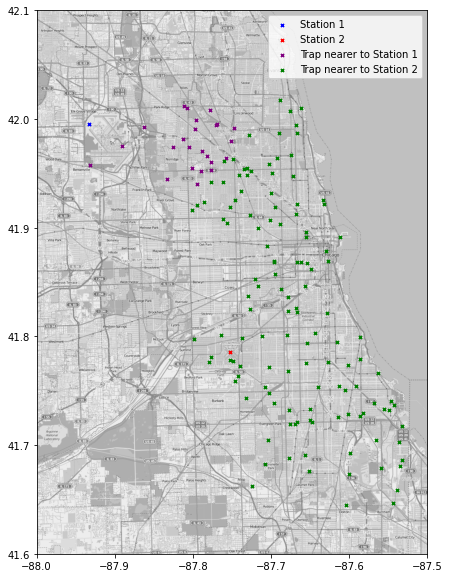

In [13]:
mapdata = np.loadtxt("../BackupData/mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")
                     
#traps = pd.read_csv('./datasets/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect='auto')

plt.scatter(-87.933, 41.995, marker='x', s= 10, c='blue', label='Station 1')
plt.scatter(-87.752, 41.786, marker='x', s= 10, c='red', label='Station 2')


locations = train_station_1[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', s= 10, c='purple', label='Trap nearer to Station 1');

locations2 = train_station_2[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations2[:,0], locations2[:,1], marker='x', s= 10, c='green', label='Trap nearer to Station 2');
plt.legend();

In [16]:
merge_df_weather = merge_df.merge(weather, on = ['date','station'], how = 'left')

In [17]:
merge_df_weather.head()

,date,species,latitude,longitude,trap,nummosquitos,wnvpresent,wnvcount,station,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,month,sunrise,sunset,bcfg,br,dz,fg,fg+,fu,hz,mifg,ra,sn,sq,ts,tsra,vcts,gr,vcfg
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.867108,-87.654224,T048,1.0,0.0,0.0,2,88,65,76.5,59,66.0,0.0,12.0,BR HZ,0.0,29.44,30.09,5.8,16,7.4,5,4.35,19.283333,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0.0,0.0
1,2007-05-29,CULEX RESTUANS,41.867108,-87.654224,T048,2.0,0.0,0.0,2,88,65,76.5,59,66.0,0.0,12.0,BR HZ,0.0,29.44,30.09,5.8,16,7.4,5,4.35,19.283333,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0.0,0.0
2,2007-05-29,CULEX RESTUANS,41.862292,-87.648860,T091,1.0,0.0,0.0,2,88,65,76.5,59,66.0,0.0,12.0,BR HZ,0.0,29.44,30.09,5.8,16,7.4,5,4.35,19.283333,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0.0,0.0
3,2007-05-29,CULEX RESTUANS,41.896282,-87.655232,T049,1.0,0.0,0.0,2,88,65,76.5,59,66.0,0.0,12.0,BR HZ,0.0,29.44,30.09,5.8,16,7.4,5,4.35,19.283333,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0.0,0.0
4,2007-05-29,CULEX RESTUANS,41.907645,-87.760886,T153,1.0,0.0,0.0,2,88,65,76.5,59,66.0,0.0,12.0,BR HZ,0.0,29.44,30.09,5.8,16,7.4,5,4.35,19.283333,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0.0,0.0


<font color='red'>
    
# UNABLE TO RUN CODE IN SECTION BELOW

</font>

weather_lag_combined is not defined<br/>
is it meant to be merge_df + weather_cleaned_lag.csv + .apply(closest_station)<br/>
or something like that?

In [ ]:
# weather_lag_combined is not defined
# is it meant to be merge_df + weather_cleaned_lag.csv + .apply(closest_station)
# or something like that?

In [ ]:
# merge weather lag data with train/test dataset

In [ ]:
lag_dates = ['date_2_lag', 'date_3_lag', 'date_5_lag', 'date_7_lag', 'date_14_lag',
       'date_21_lag', 'date_28_lag']

for col in lag_dates:
    weather_lag[col] = pd.to_datetime(weather_lag[col])

In [ ]:
def merge_lag_dfs(lag_date):
    new_merge_df = merge_df.merge(
    weather_lag_combined,
    left_on=['date', 'station'],
    right_on=[lag_date, 'station'],
    how='left'
    )

    new_merge_df.drop(columns=lag_dates, axis=1, inplace=True)
    
    return new_merge_df

In [ ]:
merge_df_weather_2_lag = merge_lag_dfs('date_2_lag')
merge_df_weather_3_lag = merge_lag_dfs('date_3_lag')
merge_df_weather_5_lag = merge_lag_dfs('date_5_lag')
merge_df_weather_7_lag = merge_lag_dfs('date_7_lag')
merge_df_weather_14_lag = merge_lag_dfs('date_14_lag')
merge_df_weather_21_lag = merge_lag_dfs('date_21_lag')
merge_df_weather_28_lag = merge_lag_dfs('date_28_lag')

In [ ]:
merge_df_weather_2_lag.to_csv(r'../data/weather_cleaned_lag2.csv', index = False)
merge_df_weather_3_lag.to_csv(r'../data/weather_cleaned_lag3.csv', index = False)
merge_df_weather_5_lag.to_csv(r'../data/weather_cleaned_lag5.csv', index = False)
merge_df_weather_7_lag.to_csv(r'../data/weather_cleaned_lag7.csv', index = False)
merge_df_weather_14_lag.to_csv(r'../data/weather_cleaned_lag14.csv', index = False)
merge_df_weather_21_lag.to_csv(r'../data/weather_cleaned_lag21.csv', index = False)
merge_df_weather_28_lag.to_csv(r'../data/weather_cleaned_lag28.csv', index = False)

### Merging spray data with weather/train/test dataset

In [18]:
spray.head()

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [19]:
def spray_within_days(row, dist=0.001):
    
    # Accessing the tested mozzie trap's Latitude & Longitude.
    lat = row['latitude']
    lon = row['longitude']
    date = row['date']
    
    spray_filtered = spray[(spray['date'] == date)]
    
    for i in spray_filtered.index:
        
        # Calculating euclidean distance between the row's location and the spray's location (using values in Latitude and Longitude columns)
        spray_dist = ((spray.loc[i, 'latitude'] - lat) ** 2 + (spray.loc[i, 'longitude'] - lon) ** 2) ** 0.5
        
        # So if the calculated distance is <= distance value given as input, the tested trap is considered sprayed, so return 1.
        if spray_dist <= dist:
            return 1
    
    # Return 0 (mozzie trap not sprayed) if spray_dist > dist.
    return 0

In [20]:
merge_weather_spray = merge_df_weather.copy()
merge_weather_spray['sprayed'] = merge_df_weather.apply(spray_within_days, axis=1)

In [21]:
merge_weather_spray['sprayed'].value_counts()

0    124758
1        10
Name: sprayed, dtype: int64

In [22]:
merge_weather_spray.sort_values(by = 'nummosquitos', inplace = True)

### Save merged (train + weather + spray) as csv
Dataset is for EDA and exploration

In [24]:
merge_weather_spray.shape

(124768, 43)

In [23]:
train_merged = merge_weather_spray.iloc[0:8475]
# check no NAN
train_merged.isnull().sum()

date            0
species         0
latitude        0
longitude       0
trap            0
nummosquitos    0
wnvpresent      0
wnvcount        0
station         0
tmax            0
tmin            0
tavg            0
dewpoint        0
wetbulb         0
heat            0
cool            0
codesum         0
preciptotal     0
stnpressure     0
sealevel        0
resultspeed     0
resultdir       0
avgspeed        0
month           0
sunrise         0
sunset          0
bcfg            0
br              0
dz              0
fg              0
fg+             0
fu              0
hz              0
mifg            0
ra              0
sn              0
sq              0
ts              0
tsra            0
vcts            0
gr              0
vcfg            0
sprayed         0
dtype: int64

In [25]:
test_merged = merge_weather_spray.iloc[8475:]
# check no NAN and cross check test original shape
print(f'Sum of null values in nummosquitos: {test_merged.nummosquitos.isnull().sum()}')
print(test.shape)

# check head if there are any values in nummosquitos | wnvcount	| wnvpresent
test_merged.head(3)

Sum of null values in nummosquitos: 116293
(116293, 5)


,date,species,latitude,longitude,trap,nummosquitos,wnvpresent,wnvcount,station,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,month,sunrise,sunset,bcfg,br,dz,fg,fg+,fu,hz,mifg,ra,sn,sq,ts,tsra,vcts,gr,vcfg,sprayed
8475,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,T002,NaN,NaN,NaN,1,86,61,73.5,56,64.0,0.0,9.0,,0.0,29.28,29.99,8.9,18,10.0,6,4.266667,19.433333,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0
8476,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,T002,NaN,NaN,NaN,1,86,61,73.5,56,64.0,0.0,9.0,,0.0,29.28,29.99,8.9,18,10.0,6,4.266667,19.433333,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0
8477,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,T002,NaN,NaN,NaN,1,86,61,73.5,56,64.0,0.0,9.0,,0.0,29.28,29.99,8.9,18,10.0,6,4.266667,19.433333,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0


In [26]:
# drop columns for test_merged_weather set 

test_merged = test_merged.drop(columns = ['nummosquitos','wnvcount', 'wnvpresent'])

In [27]:
# Save cleaned data to csv

train_merged.to_csv(r'../data/merged_train.csv', index = False) # Combined both weather and spray data
#test_merged.to_csv(r'../data/merged_test.csv', index = False) # Combined both weather and spray data

## Further EDA Analysis

In [ ]:
# read in merged data

train_merged = pd.read_csv('../data/merged_train.csv')
train_merged['date'] = pd.to_datetime(train_merged['date'])

In [ ]:
train_merged.head()

In [ ]:
# create week column 
train_merged['week'] = train_merged.loc[:,'date'].dt.isocalendar().week
train_merged['year'] = train_merged.loc[:,'date'].dt.year

In [ ]:
# monthly trend of average temperature
train_merged.groupby('month').mean()[['wnvpresent']].plot.bar()
plt.xlabel('Month in a year')
plt.ylabel('Temperature')
plt.title('Month vs WnvPresent', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.xticks(rotation=0);

In [ ]:
# define function that takes in df and which year to produce trend for num of mosquitos, vs wnvpresent and tavg

def plot_trend_wnv(df, year):
    dataset = df[df['year']== year]
    # creating separate df to compile SUM of mosquitos by species
    dataset_sub = dataset[(dataset['species']== 'CULEX PIPIENS') | (dataset['species']== 'CULEX RESTUANS') | (dataset['species']== 'CULEX PIPIENS/RESTUANS')]

    dataset_sub = dataset_sub.groupby(['month', 'week','species']).sum()['nummosquitos'].reset_index()
    dataset_sub[dataset_sub.species == 'CULEX PIPIENS']

    new_df = dataset_sub[['month', 'week']]
    new_df.loc[:,'pipiens_num'] = dataset_sub[dataset_sub.species == 'CULEX PIPIENS']['nummosquitos']
    new_df.loc[:,'restuans_num'] = dataset_sub[dataset_sub.species == 'CULEX RESTUANS']['nummosquitos']
    new_df.loc[:,'mix_pip&restuans_num'] = dataset_sub[dataset_sub.species == 'CULEX PIPIENS/RESTUANS']['nummosquitos']

    new_df = new_df.groupby(['week','month']).mean()

    # Plot subsplots with main y-axis = Sum of No. of mosquitos 
    fig, ax1 = plt.subplots() 

    new_df.plot.bar(figsize= (30,10), ax = ax1)

    # set labels for left y-axis 
    plt.ylabel('Sum of No. of mosquitos by Species', fontdict={'size': 20}) 
    plt.xlabel('By (Week, Month)', fontdict={'size': 20}) 
    plt.xticks(rotation=0, size= 12)
    plt.yticks(size= 12)


    # create df for wnv and tavg line plots 
    analyse_df1 = dataset.groupby(['week','month']).sum()[['wnvpresent']]
    analyse_df2 = dataset.groupby(['week']).mean()[['tavg']].reset_index().drop(columns= ['week'])

    # Adding Twin Axes for wnvpresent (Red solid line )
    ax2 = ax1.twinx()  

    analyse_df1.plot.line(figsize= (30,10), ax = ax2, color = 'red')

    plt.legend(loc='upper left')

    # Adding Twin Axes for tavg (Dark Blue Dotted Line)
    analyse_df2.plot.line(figsize= (30,10), ax = ax2, color = 'darkblue', ls =  '--', lw = 3)
    plt.ylim(0,120)
    plt.legend(loc='upper left')

    # Add label
    plt.title(f'WnvPresent trend in {year}', fontsize= 20, weight = 'bold')
    plt.ylabel('Sum of WnvPresent | Average Temperature') 

    # Show plot
    plt.grid(color = 'black', linestyle = '-.', linewidth = 0.5)
    plt.show()

In [ ]:
# plot yearly trends and compare if spray/avg temp has an impact 
years = [2007,2009,2011,2013]

for year in years:
    plot_trend_wnv(train_merged,year)

Key Observations
1) In 2007 and 2013, there seems to be a peak of Wnvpresent during month of August. As for the other two years, there seem to be lesser mosquitos caught generally. This suggest that there might be some other factors that may influence the breeding of mosquitos. 
2) Across all years, `restuans species` population peaks during mid to end July while `Pipiens species` will tend to peak during August. 
3) We did notice that when `restuans` peaked, `wnvpresent` counts did not see spike, however when `pipiens` started to rise, `wnvpresent` starts to spike upwards as well. This suggest that there is a slight chance having spots with 
4) We can see that in different years, the months display `inconsistent peaks` in `wnvpresent`


In [ ]:
# monthly trend of average temperature
train_merged.groupby('month').mean()[['heat', 'cool']]

This should not be in continuous variable analysis as it depicts average cooling or heating component during hot and cold seasons. 
Naturally if we see on August having very high temp, for sure heating will be set at zero and cooling will be set at max. As temperature is believe to be a crucial factor to mosquito activity based ([source](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity)), the higher the temp, the higher the cooling effect needed to dampen the overall temp, displaying positive correlation. It will not make sense to compare with the number of mosquitos as it will sure show positive correlation of cooling effect to num of mosquitos. This high collinearity may have impact on the model results. We can explore both in our models and test based on mse and also view correlation to num of mosquitos.

### Analysis on what correlates to num of mosquitos 

In [ ]:
continuous_var = ['tavg','dewpoint','wetbulb','preciptotal','stnpressure','sealevel','resultspeed',
 'resultdir','avgspeed','br','dz','fg','hz','ra','ts','nummosquitos']

In [ ]:
impt_features = train_merged[continuous_var]

Checking code sum should only have these based on Daily Table format given by Kaggle 

`TS` - Thunderstorm

`RA` - Rain

`FG` - Fog

`FG+` - Heavy Fog 

`BR` - Mist

`DZ` - Drizzle 

`HZ` - Haze




In [ ]:
cont_var = [col for col in merge_df_weather if \
    (merge_df_weather[col].dtypes != 'O') &\
    (col not in ['date','latitude', 'longitude', 'wnvcount', 'station', 'sunrise', 'sunset','heat','cool'])]

heatmap_df = merge_df_weather[cont_var].loc[0:8474]
heatmap_df.drop(columns = ['bcfg', 'fg+','fu','mifg','sn','sq','gr','vcfg'], inplace = True)

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(heatmap_df.corr()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 230, as_cmap=True)

# Draw the heatmap_df with the mask and correct aspect ratio
sns.heatmap(heatmap_df.corr(), mask=mask, cmap=cmap, vmax=0.5, vmin = -0.5,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

In [ ]:
heatmap_df.corr()['wnvpresent'].sort_values(ascending = False)

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

From the heatmap, few observations were observed. 

1) Generally, having `tavg`, `wetbulb`, `thunderstorm`, `rain` have a positive correlation with number of mosquitoes while `preciptotal`, `sealevel`, `resultspeed` and `drizzle` has a slight negative correlation. These features may be usefull in modelling later on. 
2) We can see that `dewpoint` and `wetbulb` is highly correlated to `avg temperature`, suggesting that overall temperature has influence on the two variables. The `higher the dewpoint and temperature`, the `higher the relatively humidity` of the environment. Based on ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7068582/)), `humidity` shows `positive correlation` with the `numbers of species sampled from the traps`. 
3) Both `avgspeed and resultspeed` has a negative correlation to the num of mosquitos, indicating that the strong the wind, the lesser the mosquitos. Based on ([source](https://kestrelmeters.com/blogs/news/the-science-of-mosquito-abatement#:~:text=Wind%20works%20as%20a%20natural,MPH%20wind%20gust%20is%20substantial)), strong wind serves as natural repellent as mosquitos cannot fly through strong wind. 
4) The average speed has relative high correlation to weather conditions like `thunderstorm` and `drizzle` suggesting its used to help predict weather patterns and global climate.
5) `Preciptotal`, `drizzle`, `tsra: moderate thunderstorm and rain` seems to have a negative correlation to number of mosquitos, probably due to the skewness of the distribution of precipitation levels. This is unexpected, as usually, it is understood that mosquitos need water to start breeding. However, based on ([source](https://maggiesfarmproducts.com/blogs/bug-help/weather-mosquito-activity#:~:text=Moisture%20plays%20an%20important%20role,to%20an%20increase%20in%20breeding.)), it seems like heavier rain will make it difficult for them to fly. \\
6) `vcts` which stands for `Vicinity thunderstorm`, has negative correlation to `wnvpresent` due to the fact that severe weathers like this occurs on the warm side of the warm front, where the greatest directional wind shear is located near that warm front boundary. Hence stronger wind would repel mosquitos. ([weather.gov](https://www.weather.gov/source/zhu/ZHU_Training_Page/thunderstorm_stuff/Thunderstorms/thunderstorms.htm))